## Libraries

### Data Manipulation

In [1]:
import pandas as pd
import csv
import os
import re
import numpy as np

### Plotting

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pretty_confusion_matrix import pp_matrix_from_data

### Data pre-processing

In [3]:
import nltk
import sklearn
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from tqdm import tqdm

### Modeling/Training

In [4]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn import metrics

import scipy
from scipy import stats

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, Conv1D, GlobalMaxPooling1D, SimpleRNN, GlobalMaxPool1D, Dropout, BatchNormalization, AveragePooling1D, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, History, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.metrics import CategoricalAccuracy

### Create requirements.txt

In [5]:
with open('requirements.txt', 'w') as file:
    file.writelines(f'pandas=={pd.__version__}\n')
    file.writelines(f'numpy=={np.__version__}\n')
    file.writelines(f'nltk=={nltk.__version__}\n')
    file.writelines(f'sklearn=={sklearn.__version__}\n')
    file.writelines(f'scipy=={scipy.__version__}\n')
    file.writelines(f'tensorflow=={tf.__version__}\n')

## Data Loading

In [6]:
# Load the data
train = pd.read_csv('data/train_combined_imbalanced.csv')
validation = pd.read_csv('data/validation.csv')
inference = pd.read_csv('data/inference_from_8606.csv')

# Shape of the files
print('>train data - ', train.shape)
print('>validation data - ', validation.shape)
print('>inference data - ', inference.shape)

>train data -  (2405, 3)
>validation data -  (405, 3)
>inference data -  (300, 3)


## Data Pre-processing

### Functions for pre-processing

In [7]:
# Function to extract the contracted text from the data
def decontracted(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [8]:
# Function to lower the textcase
def lower_case(text):
    return text.lower()

In [9]:
# Function to remove tags to avoid noise in the data
def remove_tag(text):
    return re.sub(r'<.*?>', ' ', text)

In [10]:
# Remove stopwords from the text
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_stopwords(text):
    result = ' '.join([word for word in text if word not in stop])
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mathews\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Lemmatization
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def lemmatization(text):
    result = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    return result   

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mathews\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mathews\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# Tokenize the text
nltk.download('punkt')

def tokenize_text(text):
    return word_tokenize(text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mathews\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
# Function to preprocess the data by calling all the methods defined above
def preprocess(text):

    text = lower_case(text)
    text = remove_tag(text)
    text = decontracted(text)
    text = tokenize_text(text)
    text = remove_stopwords(text)
    text = lemmatization(text)
    
    return text

### Pre-processing

In [14]:
# Create a new column to hold the clean questions
train['clean_Question'] = train['Question'].apply(preprocess)
validation['clean_Question'] = validation['Question'].apply(preprocess)
inference['clean_Question'] = inference['Question'].apply(preprocess)

# Rearrange the columns
train = train[['Question', 'clean_Question', 'Answer', 'Label']]
validation = validation[['Question', 'clean_Question', 'Answer', 'Label']]
inference = inference[['Question', 'clean_Question', 'Answer', 'Label']]

In [15]:
train.sample(2)

,Question,clean_Question,Answer,Label
4,How does conceptual gap in exploring climate c...,conceptual gap exploring climate change risk a...,The conceptual gap in exploring climate change...,ethics and regulation
605,How can universities respond to climate change...,university respond climate change institutiona...,Universities can respond to climate change at ...,strategy


## Modeling/Training

### Train/Test split

In [171]:
# Get the train-test split of the training data and labels_dummy
x_train, x_test, y_train, y_test = train_test_split(train['clean_Question'].values, train['Label'].values, test_size=0.2, random_state=42, shuffle=True, stratify=train['Label'])
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1924,), (1924,), (481,), (481,))

In [172]:
# One-hot-encode labels
labels_train_dummy = pd.get_dummies(y_train)
labels_test_dummy = pd.get_dummies(y_test)

encoder = LabelEncoder()
y_train_onehot = encoder.fit_transform(y_train)
y_test_onehot = encoder.fit_transform(y_test)

### Variables

In [170]:
maxlen = 100
max_features = 3000
embed_size = 128
learning_rate = 0.0001
epochs = 50
batch_size=128

### Callbacks

In [18]:
# define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, restore_best_weights=True)

In [19]:
# Call learningratescheduler
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

learning_rate_sched = ReduceLROnPlateau(monitory='val_accuracy', patience=3, verbose=1, min_lr=1e-5)

### Tokenization

In [173]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [174]:
word_index = tokenizer.word_index
len(word_index)

2925

### Glove Embedding

In [23]:
glove_path = 'C:/Users/Mathews/Documents/Projects/Qutii/glove.840B.300d/glove.840B.300d.txt'

In [24]:
# Load the GloVe vectors in a dictionary

embeddings_index = {}
f = open(glove_path,'r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [02:45, 13299.78it/s]

Found 2196016 word vectors.


In [175]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 2925/2925 [00:00<00:00, 385493.77it/s]


In [176]:
embedding_matrix.shape

(2926, 300)

### Model definition

In [97]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 645       
Total params: 1,065,325
Trainable params: 187,525
Non-trainable params: 877,800
_________________________________________________________________


In [98]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [99]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 3s 75ms/step - loss: 1.5368 - accuracy: 0.3571 - val_loss: 1.4139 - val_accuracy: 0.5052
Epoch 2/50
16/16 [==============================] - 1s 46ms/step - loss: 1.3335 - accuracy: 0.5348 - val_loss: 1.2545 - val_accuracy: 0.5468
Epoch 3/50
16/16 [==============================] - 1s 44ms/step - loss: 1.1825 - accuracy: 0.5722 - val_loss: 1.1573 - val_accuracy: 0.5593
Epoch 4/50
16/16 [==============================] - 1s 46ms/step - loss: 1.0818 - accuracy: 0.6040 - val_loss: 1.1162 - val_accuracy: 0.5551
Epoch 5/50
16/16 [==============================] - 1s 46ms/step - loss: 1.0038 - accuracy: 0.6325 - val_loss: 1.0817 - val_accuracy: 0.5904
Epoch 6/50
16/16 [==============================] - 1s 44ms/step - loss: 0.9600 - accuracy: 0.6429 - val_loss: 1.0614 - val_accuracy: 0.5925
Epoch 7/50
16/16 [==============================] - 1s 47ms/step - loss: 0.9154 - accuracy: 0.6590 - val_loss: 1.0574 - val_accuracy: 0.6008
Epoch 8/50
16

In [101]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63        92
           1       0.67      0.74      0.70        87
           2       0.43      0.37      0.40        86
           3       0.69      0.72      0.70       114
           4       0.56      0.56      0.56       102

    accuracy                           0.61       481
   macro avg       0.60      0.60      0.60       481
weighted avg       0.60      0.61      0.61       481



In [37]:
encoder.classes_

array(['analysis', 'ethics and regulation', 'others', 'science and tech',
       'strategy'], dtype=object)

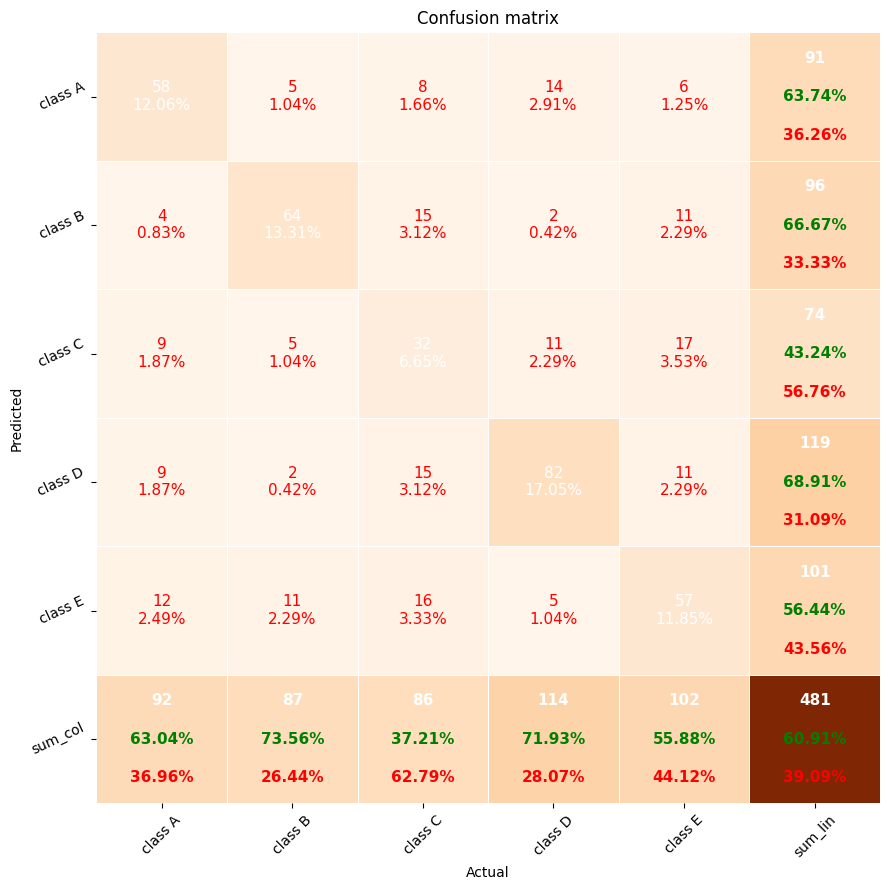

In [102]:
# get the confusion matrix
pp_matrix_from_data(encoder.inverse_transform(y_test_onehot), encoder.inverse_transform(y_pred))

In [103]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 5)                 1285      
Total params: 1,329,133
Trainable params: 451,333
Non-trainable params: 877,800
_______________________________________

In [104]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [105]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 6s 140ms/step - loss: 1.5149 - accuracy: 0.3805 - val_loss: 1.3251 - val_accuracy: 0.4948
Epoch 2/50
16/16 [==============================] - 1s 89ms/step - loss: 1.2425 - accuracy: 0.5260 - val_loss: 1.1559 - val_accuracy: 0.5613
Epoch 3/50
16/16 [==============================] - 1s 88ms/step - loss: 1.1113 - accuracy: 0.5691 - val_loss: 1.0939 - val_accuracy: 0.5946
Epoch 4/50
16/16 [==============================] - 1s 86ms/step - loss: 1.0072 - accuracy: 0.6195 - val_loss: 1.0549 - val_accuracy: 0.5863
Epoch 5/50
16/16 [==============================] - 1s 86ms/step - loss: 0.9387 - accuracy: 0.6476 - val_loss: 1.0683 - val_accuracy: 0.6154
Epoch 6/50
16/16 [==============================] - 1s 89ms/step - loss: 0.8655 - accuracy: 0.6835 - val_loss: 1.0740 - val_accuracy: 0.5613
Epoch 7/50
16/16 [==============================] - 1s 87ms/step - loss: 0.8248 - accuracy: 0.6881 - val_loss: 1.1203 - val_accuracy: 0.5696
Epoch 8/50
1

In [106]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61        92
           1       0.72      0.71      0.72        87
           2       0.45      0.47      0.46        86
           3       0.76      0.68      0.72       114
           4       0.54      0.58      0.56       102

    accuracy                           0.62       481
   macro avg       0.62      0.61      0.61       481
weighted avg       0.62      0.62      0.62       481



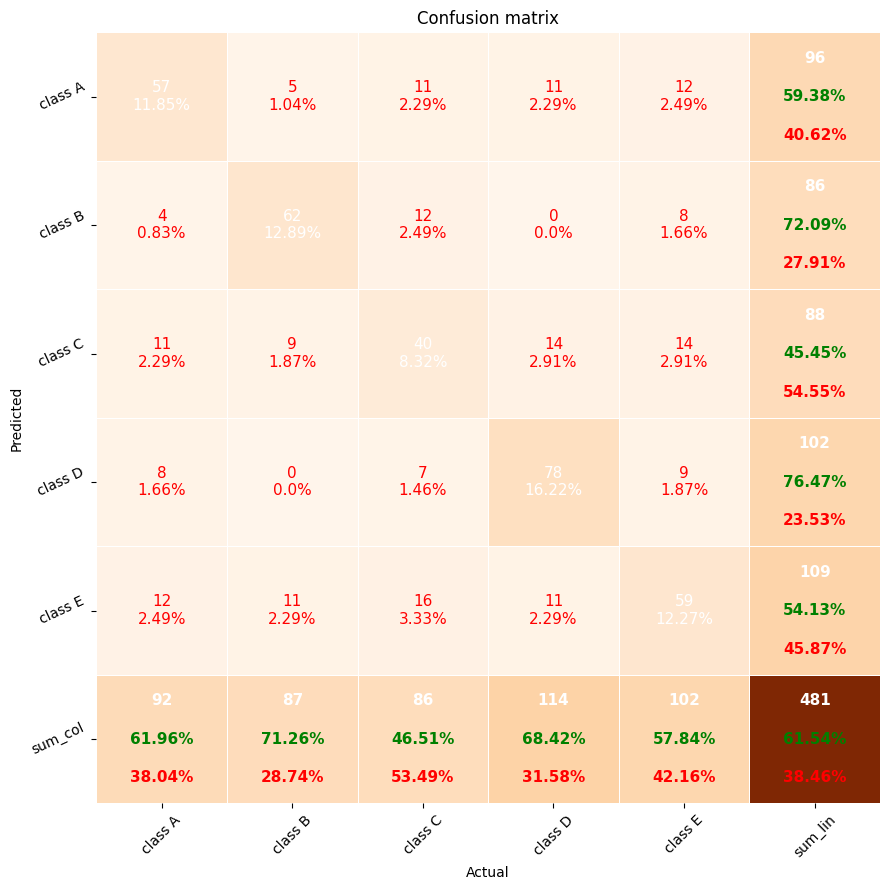

In [107]:
# get the confusion matrix
pp_matrix_from_data(encoder.inverse_transform(y_test_onehot), encoder.inverse_transform(y_pred))

In [108]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 256, 512)          1050624   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 5)               

In [109]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [110]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 8s 224ms/step - loss: 1.4705 - accuracy: 0.3659 - val_loss: 1.3869 - val_accuracy: 0.4241
Epoch 2/50
16/16 [==============================] - 2s 149ms/step - loss: 1.2336 - accuracy: 0.5031 - val_loss: 1.2443 - val_accuracy: 0.4927
Epoch 3/50
16/16 [==============================] - 2s 146ms/step - loss: 1.1063 - accuracy: 0.5759 - val_loss: 1.1580 - val_accuracy: 0.5551
Epoch 4/50
16/16 [==============================] - 2s 140ms/step - loss: 1.0137 - accuracy: 0.5951 - val_loss: 1.0839 - val_accuracy: 0.5738
Epoch 5/50
16/16 [==============================] - 2s 143ms/step - loss: 0.9644 - accuracy: 0.6367 - val_loss: 1.0840 - val_accuracy: 0.5738
Epoch 6/50
16/16 [==============================] - 2s 145ms/step - loss: 0.8762 - accuracy: 0.6627 - val_loss: 1.1086 - val_accuracy: 0.5759
Epoch 7/50
16/16 [==============================] - 2s 141ms/step - loss: 0.8127 - accuracy: 0.6985 - val_loss: 1.1390 - val_accuracy: 0.5884
Epoch 

In [111]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59        92
           1       0.63      0.74      0.68        87
           2       0.47      0.42      0.44        86
           3       0.66      0.73      0.69       114
           4       0.58      0.50      0.54       102

    accuracy                           0.60       481
   macro avg       0.59      0.59      0.59       481
weighted avg       0.59      0.60      0.59       481



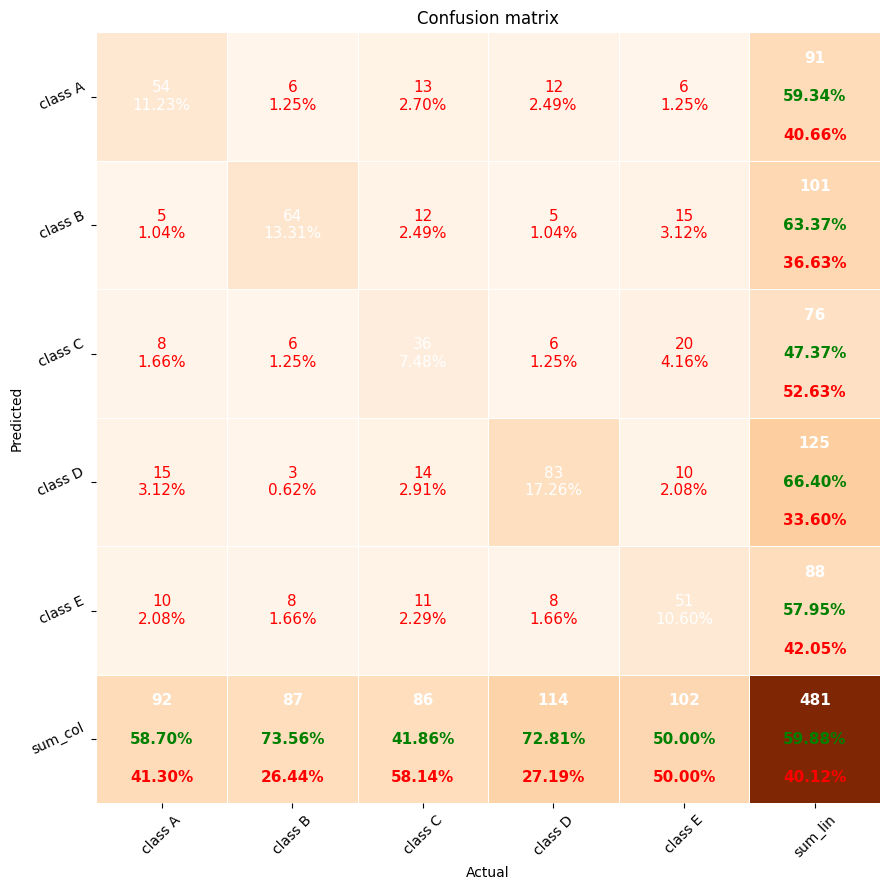

In [112]:
# get the confusion matrix
pp_matrix_from_data(encoder.inverse_transform(y_test_onehot), encoder.inverse_transform(y_pred))

In [113]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(256, dropout=0.7, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 256, 512)          1050624   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)               

In [114]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [115]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 8s 228ms/step - loss: 1.4824 - accuracy: 0.3540 - val_loss: 1.2989 - val_accuracy: 0.4699
Epoch 2/50
16/16 [==============================] - 2s 148ms/step - loss: 1.2432 - accuracy: 0.5198 - val_loss: 1.1941 - val_accuracy: 0.5530
Epoch 3/50
16/16 [==============================] - 2s 148ms/step - loss: 1.1173 - accuracy: 0.5639 - val_loss: 1.1175 - val_accuracy: 0.5863
Epoch 4/50
16/16 [==============================] - 2s 149ms/step - loss: 1.0193 - accuracy: 0.6149 - val_loss: 1.1066 - val_accuracy: 0.5676
Epoch 5/50
16/16 [==============================] - 2s 145ms/step - loss: 1.0108 - accuracy: 0.6123 - val_loss: 1.1282 - val_accuracy: 0.5509
Epoch 6/50
16/16 [==============================] - 2s 151ms/step - loss: 0.9612 - accuracy: 0.6227 - val_loss: 1.0981 - val_accuracy: 0.5676
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [116]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.61      0.60        92
           1       0.58      0.76      0.66        87
           2       0.49      0.21      0.29        86
           3       0.64      0.76      0.70       114
           4       0.56      0.54      0.55       102

    accuracy                           0.59       481
   macro avg       0.57      0.58      0.56       481
weighted avg       0.57      0.59      0.57       481



In [117]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 256)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 1285      
Total params: 1,329,133
Trainable params: 451,333
Non-trainable params: 877,800
_______________________________________

In [118]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [119]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 6s 150ms/step - loss: 1.5383 - accuracy: 0.3425 - val_loss: 1.3948 - val_accuracy: 0.4470
Epoch 2/50
16/16 [==============================] - 1s 93ms/step - loss: 1.3036 - accuracy: 0.4756 - val_loss: 1.1974 - val_accuracy: 0.5281
Epoch 3/50
16/16 [==============================] - 1s 93ms/step - loss: 1.1459 - accuracy: 0.5593 - val_loss: 1.1325 - val_accuracy: 0.5530
Epoch 4/50
16/16 [==============================] - 1s 94ms/step - loss: 1.0420 - accuracy: 0.5910 - val_loss: 1.0875 - val_accuracy: 0.5800
Epoch 5/50
16/16 [==============================] - 1s 92ms/step - loss: 0.9836 - accuracy: 0.6206 - val_loss: 1.0967 - val_accuracy: 0.5634
Epoch 6/50
16/16 [==============================] - 1s 94ms/step - loss: 0.9553 - accuracy: 0.6242 - val_loss: 1.0771 - val_accuracy: 0.5696
Epoch 7/50
16/16 [==============================] - 1s 93ms/step - loss: 0.9045 - accuracy: 0.6544 - val_loss: 1.0806 - val_accuracy: 0.5904
Epoch 8/50
1

In [120]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63        92
           1       0.72      0.71      0.72        87
           2       0.44      0.41      0.42        86
           3       0.73      0.68      0.70       114
           4       0.50      0.60      0.54       102

    accuracy                           0.60       481
   macro avg       0.61      0.60      0.60       481
weighted avg       0.61      0.60      0.61       481



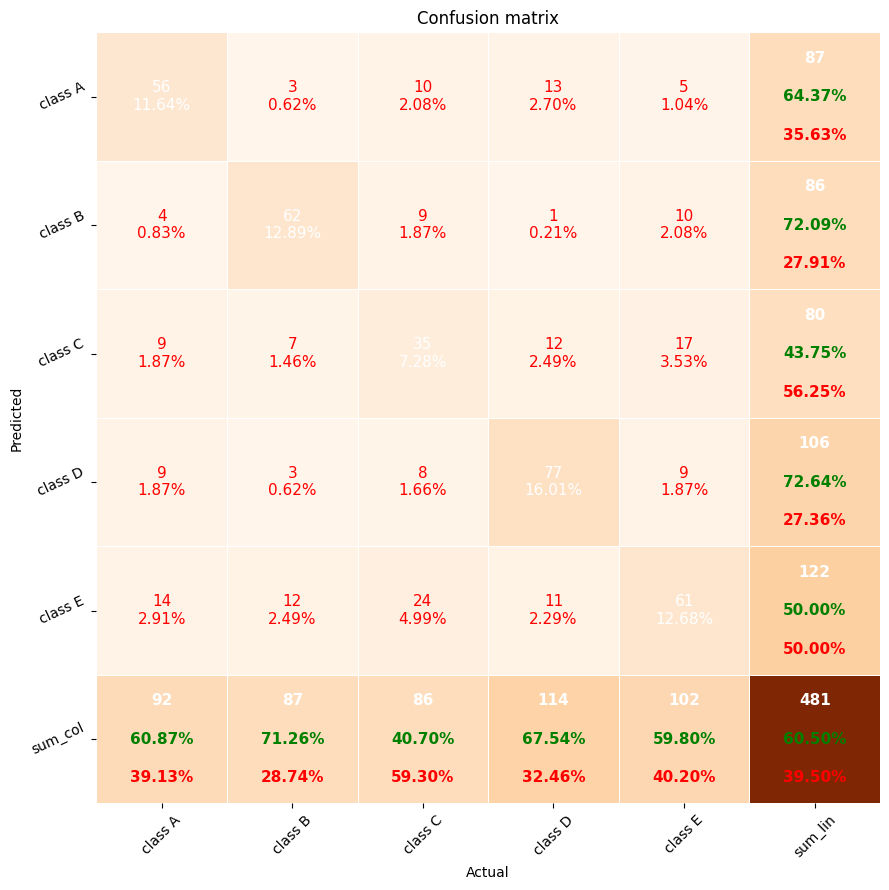

In [121]:
# get the confusion matrix
pp_matrix_from_data(encoder.inverse_transform(y_test_onehot), encoder.inverse_transform(y_pred))

In [123]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 256, 300)          0         
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 256)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)               

In [124]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [125]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.18      0.86      0.30        92
           1       0.00      0.00      0.00        87
           2       0.00      0.00      0.00        86
           3       0.23      0.08      0.12       114
           4       0.40      0.02      0.04       102

    accuracy                           0.19       481
   macro avg       0.16      0.19      0.09       481
weighted avg       0.17      0.19      0.09       481



c:\Users\Mathews\.conda\envs\tf-gpu-new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mathews\.conda\envs\tf-gpu-new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mathews\.conda\envs\tf-gpu-new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [126]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 6s 136ms/step - loss: 1.5864 - accuracy: 0.2760 - val_loss: 1.5142 - val_accuracy: 0.3701
Epoch 2/50
16/16 [==============================] - 1s 83ms/step - loss: 1.4913 - accuracy: 0.3867 - val_loss: 1.3335 - val_accuracy: 0.4823
Epoch 3/50
16/16 [==============================] - 1s 86ms/step - loss: 1.3993 - accuracy: 0.4272 - val_loss: 1.2245 - val_accuracy: 0.5281
Epoch 4/50
16/16 [==============================] - 1s 83ms/step - loss: 1.3172 - accuracy: 0.4558 - val_loss: 1.1742 - val_accuracy: 0.5177
Epoch 5/50
16/16 [==============================] - 1s 87ms/step - loss: 1.2709 - accuracy: 0.4839 - val_loss: 1.1884 - val_accuracy: 0.5301
Epoch 6/50
16/16 [==============================] - 1s 85ms/step - loss: 1.2750 - accuracy: 0.4808 - val_loss: 1.1411 - val_accuracy: 0.5717
Epoch 7/50
16/16 [==============================] - 1s 83ms/step - loss: 1.2205 - accuracy: 0.5140 - val_loss: 1.1272 - val_accuracy: 0.5593
Epoch 8/50
1

In [127]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
#model.add(GlobalMaxPool1D())
model.add(AveragePooling1D())
model.add(Flatten())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 256, 256)          263168    
_________________________________________________________________
average_pooling1d_11 (Averag (None, 128, 256)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 32768)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 5)               

In [128]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [129]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 5s 137ms/step - loss: 1.4753 - accuracy: 0.3581 - val_loss: 1.2932 - val_accuracy: 0.4595
Epoch 2/50
16/16 [==============================] - 1s 88ms/step - loss: 1.1917 - accuracy: 0.5203 - val_loss: 1.1656 - val_accuracy: 0.5343
Epoch 3/50
16/16 [==============================] - 1s 91ms/step - loss: 1.0743 - accuracy: 0.5712 - val_loss: 1.1171 - val_accuracy: 0.5738
Epoch 4/50
16/16 [==============================] - 1s 84ms/step - loss: 0.9815 - accuracy: 0.6143 - val_loss: 1.1176 - val_accuracy: 0.5301
Epoch 5/50
16/16 [==============================] - 1s 85ms/step - loss: 0.9190 - accuracy: 0.6331 - val_loss: 1.1312 - val_accuracy: 0.5613
Epoch 6/50
16/16 [==============================] - 1s 89ms/step - loss: 0.8753 - accuracy: 0.6616 - val_loss: 1.0911 - val_accuracy: 0.5800
Epoch 7/50
16/16 [==============================] - 1s 82ms/step - loss: 0.7865 - accuracy: 0.7058 - val_loss: 1.1242 - val_accuracy: 0.5925
Epoch 8/50
1

In [137]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 1000, 300)         877800    
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 1000, 128)         186880    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 1000, 256)         263168    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 256)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 1285      
Total params: 1,329,133
Trainable params: 451,333
Non-trainable params: 877,800
_______________________________________

In [138]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [139]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 10s 360ms/step - loss: 1.5194 - accuracy: 0.3877 - val_loss: 1.3334 - val_accuracy: 0.5198
Epoch 2/50
16/16 [==============================] - 5s 305ms/step - loss: 1.2372 - accuracy: 0.5140 - val_loss: 1.1579 - val_accuracy: 0.5613
Epoch 3/50
16/16 [==============================] - 5s 305ms/step - loss: 1.0806 - accuracy: 0.5790 - val_loss: 1.1331 - val_accuracy: 0.5593
Epoch 4/50
16/16 [==============================] - 5s 288ms/step - loss: 1.0306 - accuracy: 0.5930 - val_loss: 1.1092 - val_accuracy: 0.5800
Epoch 5/50
16/16 [==============================] - 5s 289ms/step - loss: 1.0252 - accuracy: 0.6060 - val_loss: 1.0694 - val_accuracy: 0.6154
Epoch 6/50
16/16 [==============================] - 5s 291ms/step - loss: 0.9240 - accuracy: 0.6486 - val_loss: 1.0882 - val_accuracy: 0.5696
Epoch 7/50
16/16 [==============================] - 5s 284ms/step - loss: 0.8647 - accuracy: 0.6804 - val_loss: 1.0964 - val_accuracy: 0.5759
Epoch

In [140]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.72      0.64        92
           1       0.69      0.68      0.69        87
           2       0.50      0.22      0.31        86
           3       0.69      0.73      0.71       114
           4       0.57      0.68      0.62       102

    accuracy                           0.62       481
   macro avg       0.60      0.60      0.59       481
weighted avg       0.61      0.62      0.60       481



In [147]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 256, 64)           41216     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)                0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 325       
Total params: 1,106,221
Trainable params: 228,421
Non-trainable params: 877,800
_______________________________________

In [148]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [149]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 5s 124ms/step - loss: 1.5257 - accuracy: 0.3565 - val_loss: 1.4039 - val_accuracy: 0.4802
Epoch 2/50
16/16 [==============================] - 1s 74ms/step - loss: 1.3146 - accuracy: 0.4990 - val_loss: 1.2188 - val_accuracy: 0.5426
Epoch 3/50
16/16 [==============================] - 1s 76ms/step - loss: 1.1774 - accuracy: 0.5551 - val_loss: 1.1311 - val_accuracy: 0.5634
Epoch 4/50
16/16 [==============================] - 1s 72ms/step - loss: 1.0868 - accuracy: 0.5842 - val_loss: 1.1112 - val_accuracy: 0.5738
Epoch 5/50
16/16 [==============================] - 1s 78ms/step - loss: 1.0264 - accuracy: 0.6175 - val_loss: 1.0810 - val_accuracy: 0.5738
Epoch 6/50
16/16 [==============================] - 1s 73ms/step - loss: 0.9546 - accuracy: 0.6486 - val_loss: 1.0451 - val_accuracy: 0.5988
Epoch 7/50
16/16 [==============================] - 1s 73ms/step - loss: 0.9220 - accuracy: 0.6601 - val_loss: 1.0886 - val_accuracy: 0.5717
Epoch 8/50
1

In [150]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.63      0.62        92
           1       0.64      0.71      0.67        87
           2       0.43      0.38      0.41        86
           3       0.72      0.73      0.72       114
           4       0.60      0.57      0.59       102

    accuracy                           0.61       481
   macro avg       0.60      0.60      0.60       481
weighted avg       0.61      0.61      0.61       481



In [151]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 256, 64)           41216     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)               

In [152]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [153]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 5s 136ms/step - loss: 1.5563 - accuracy: 0.3103 - val_loss: 1.4922 - val_accuracy: 0.4033
Epoch 2/50
16/16 [==============================] - 1s 76ms/step - loss: 1.4421 - accuracy: 0.4111 - val_loss: 1.3611 - val_accuracy: 0.5322
Epoch 3/50
16/16 [==============================] - 1s 74ms/step - loss: 1.3273 - accuracy: 0.4808 - val_loss: 1.2642 - val_accuracy: 0.5509
Epoch 4/50
16/16 [==============================] - 1s 74ms/step - loss: 1.2320 - accuracy: 0.5327 - val_loss: 1.1739 - val_accuracy: 0.5572
Epoch 5/50
16/16 [==============================] - 1s 75ms/step - loss: 1.1331 - accuracy: 0.5707 - val_loss: 1.1144 - val_accuracy: 0.5634
Epoch 6/50
16/16 [==============================] - 1s 72ms/step - loss: 1.0526 - accuracy: 0.6091 - val_loss: 1.0928 - val_accuracy: 0.5717
Epoch 7/50
16/16 [==============================] - 1s 68ms/step - loss: 1.0207 - accuracy: 0.6128 - val_loss: 1.0960 - val_accuracy: 0.5759
Epoch 8/50
1

In [154]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62        92
           1       0.62      0.76      0.68        87
           2       0.46      0.14      0.21        86
           3       0.73      0.79      0.76       114
           4       0.48      0.62      0.54       102

    accuracy                           0.60       481
   macro avg       0.58      0.58      0.56       481
weighted avg       0.59      0.60      0.57       481



In [155]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 256, 300)          877800    
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 256, 128)          186880    
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 256, 64)           41216     
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_27 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)              

In [156]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [157]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 6s 125ms/step - loss: 1.5752 - accuracy: 0.2916 - val_loss: 1.4993 - val_accuracy: 0.3638
Epoch 2/50
16/16 [==============================] - 1s 70ms/step - loss: 1.4686 - accuracy: 0.3565 - val_loss: 1.3887 - val_accuracy: 0.3784
Epoch 3/50
16/16 [==============================] - 1s 69ms/step - loss: 1.3863 - accuracy: 0.3883 - val_loss: 1.3276 - val_accuracy: 0.4304
Epoch 4/50
16/16 [==============================] - 1s 72ms/step - loss: 1.3172 - accuracy: 0.4491 - val_loss: 1.2648 - val_accuracy: 0.5405
Epoch 5/50
16/16 [==============================] - 1s 73ms/step - loss: 1.2431 - accuracy: 0.5166 - val_loss: 1.1931 - val_accuracy: 0.5447
Epoch 6/50
16/16 [==============================] - 1s 69ms/step - loss: 1.1811 - accuracy: 0.5489 - val_loss: 1.1595 - val_accuracy: 0.5572
Epoch 7/50
16/16 [==============================] - 1s 70ms/step - loss: 1.1531 - accuracy: 0.5681 - val_loss: 1.1412 - val_accuracy: 0.5800
Epoch 8/50
1

In [158]:
# Get the classification report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

print(metrics.classification_report(y_test_onehot, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.61        92
           1       0.63      0.77      0.69        87
           2       0.51      0.28      0.36        86
           3       0.75      0.72      0.74       114
           4       0.53      0.67      0.59       102

    accuracy                           0.62       481
   macro avg       0.61      0.61      0.60       481
weighted avg       0.61      0.62      0.61       481



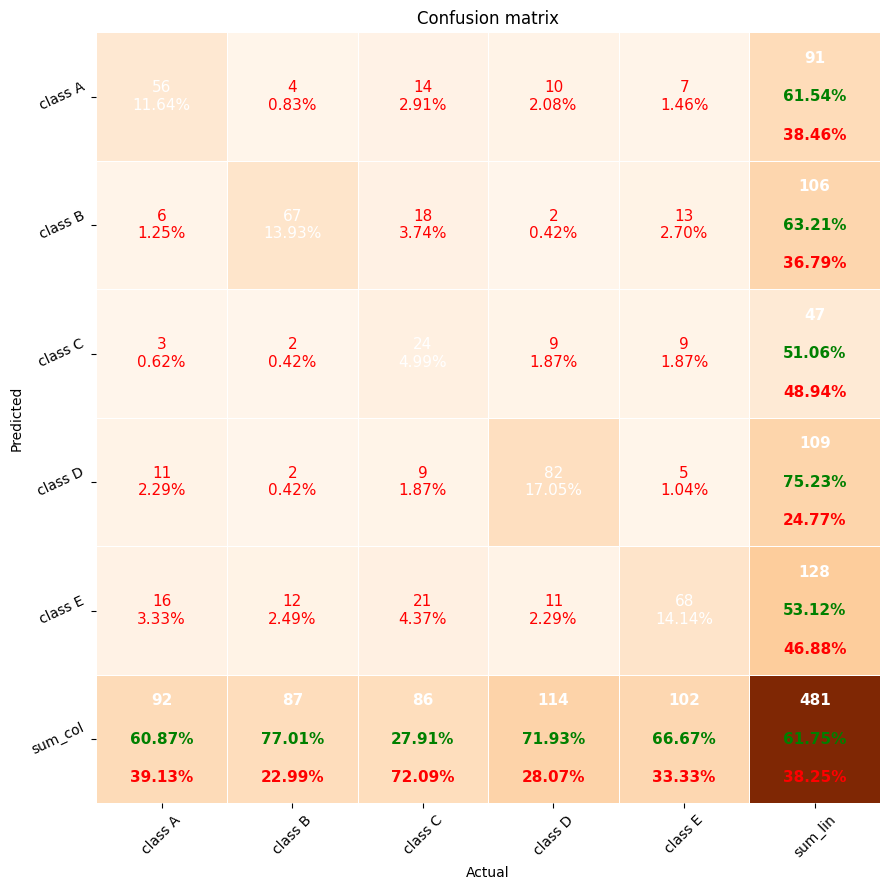

In [159]:
# get the confusion matrix
pp_matrix_from_data(encoder.inverse_transform(y_test_onehot), encoder.inverse_transform(y_pred))

In [177]:
# Define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True))
#model.add(SpatialDropout1D(0.7))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 100, 300)          877800    
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 100, 128)          186880    
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 100, 64)           41216     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_31 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 16)              

In [178]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[CategoricalAccuracy('accuracy')])

In [179]:
# train the model
history = model.fit(x_train, labels_train_dummy, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, labels_test_dummy), callbacks=[early_stop])

Epoch 1/50
16/16 [==============================] - 10s 93ms/step - loss: 1.5853 - accuracy: 0.2552 - val_loss: 1.5372 - val_accuracy: 0.3160
Epoch 2/50
16/16 [==============================] - 1s 42ms/step - loss: 1.4970 - accuracy: 0.3462 - val_loss: 1.4319 - val_accuracy: 0.3472
Epoch 3/50
16/16 [==============================] - 1s 38ms/step - loss: 1.3919 - accuracy: 0.3940 - val_loss: 1.3620 - val_accuracy: 0.4615
Epoch 4/50
16/16 [==============================] - 1s 39ms/step - loss: 1.2671 - accuracy: 0.4719 - val_loss: 1.2497 - val_accuracy: 0.5530
Epoch 5/50
16/16 [==============================] - 1s 39ms/step - loss: 1.1498 - accuracy: 0.5489 - val_loss: 1.1848 - val_accuracy: 0.5489
Epoch 6/50
16/16 [==============================] - 1s 37ms/step - loss: 1.0072 - accuracy: 0.6310 - val_loss: 1.1182 - val_accuracy: 0.5780
Epoch 7/50
16/16 [==============================] - 1s 37ms/step - loss: 0.8895 - accuracy: 0.6689 - val_loss: 1.1038 - val_accuracy: 0.6091
Epoch 8/50
1